# Librerias y Lectura Archivos

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input

In [2]:
#importacion df_final
df=pd.read_csv('../data/processed/final_merge.csv')

In [3]:
df

,edad,sexo,nivel_educativo,fumador,actividad_fisica,vive,diabetes,hipertension,obesidad,cancer,...,region_Sur,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,continente_America,continente_Antarctica,continente_Asia,continente_Europe,continente_Oceania
0,69,0,1,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
1,32,1,2,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,89,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,78,1,1,1,0,0,1,0,1,1,...,0,0,0,0,1,0,0,1,0,0
4,38,0,3,1,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47605,21,1,2,0,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
47606,35,0,3,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
47607,46,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
47608,56,1,3,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [4]:
df.shape

(47610, 48)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47610 entries, 0 to 47609
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   edad                     47610 non-null  int64  
 1   sexo                     47610 non-null  int64  
 2   nivel_educativo          47610 non-null  int64  
 3   fumador                  47610 non-null  int64  
 4   actividad_fisica         47610 non-null  int64  
 5   vive                     47610 non-null  int64  
 6   diabetes                 47610 non-null  int64  
 7   hipertension             47610 non-null  int64  
 8   obesidad                 47610 non-null  int64  
 9   cancer                   47610 non-null  int64  
 10  enfermedad_cardiaca      47610 non-null  int64  
 11  epoc                     47610 non-null  int64  
 12  glucosa                  47610 non-null  float64
 13  colesterol               47610 non-null  float64
 14  trigliceridos         

# Estandarización Variables

In [6]:
numerical_columns = ['edad', 'glucosa', 'colesterol', 'trigliceridos', 
                     'hemoglobina', 'leucocitos', 'plaquetas', 'creatinina', 
                     'ingresos_mensuales', 'gastos_salud']

In [7]:
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df[numerical_columns].head()

,edad,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,ingresos_mensuales,gastos_salud
0,0.752464,1.182348,1.148022,0.538101,-0.269240,-0.948031,0.209374,-0.325816,1.525607,2.521666
1,-1.028350,-1.578028,-1.785944,-1.386118,0.182589,-0.084302,0.732393,-0.904565,2.597109,-0.876769
2,1.715066,-0.430133,-0.698475,-2.106839,-0.762145,0.494905,-0.120001,2.664386,1.103434,-0.876769
3,1.185635,-0.245735,0.305460,-0.964549,-0.567037,1.531380,-0.126206,1.072827,-0.003326,2.521666
4,-0.739569,-1.981947,-1.579386,-2.626722,-1.193437,1.165565,-0.402064,-0.759878,0.018125,-0.876769


## Red Neuronal

In [8]:
X = df.drop(columns='vive')
y = df['vive']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # salida binaria
])


In [11]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [12]:
# 6. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.8621 - loss: 0.3780 - precision: 0.8743 - recall: 0.9836 - val_accuracy: 0.8733 - val_loss: 0.3301 - val_precision: 0.8780 - val_recall: 0.9926
Epoch 2/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.8708 - loss: 0.3354 - precision: 0.8741 - recall: 0.9948 - val_accuracy: 0.8733 - val_loss: 0.3257 - val_precision: 0.8773 - val_recall: 0.9937
Epoch 3/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.8723 - loss: 0.3283 - precision: 0.8756 - recall: 0.9944 - val_accuracy: 0.8719 - val_loss: 0.3239 - val_precision: 0.8757 - val_recall: 0.9943
Epoch 4/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.8724 - loss: 0.3299 - precision: 0.8758 - recall: 0.9945 - val_accuracy: 0.8716 - val_loss: 0.3236 - val_precision: 0.8744 - val_recall: 0.9958
Epoch 5/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.8758 - loss: 0.3184 - precision: 0.8791 - recall: 0.9948 - val_accuracy: 0.8716 - va

In [13]:
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

# 8. Resultados
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
Confusion Matrix:
 [[  88 1113]
 [  97 8224]]

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.07      0.13      1201
           1       0.88      0.99      0.93      8321

    accuracy                           0.87      9522
   macro avg       0.68      0.53      0.53      9522
weighted avg       0.83      0.87      0.83      9522

F1 Score: 0.9314758183259713


## Class Weight

In [14]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print("Pesos aplicados:", class_weight)

Pesos aplicados: {0: np.float64(3.9088669950738915), 1: np.float64(0.5733381502890174)}


In [15]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


Epoch 1/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.6879 - loss: 0.6419 - precision_1: 0.9186 - recall_1: 0.7045 - val_accuracy: 0.7600 - val_loss: 0.5566 - val_precision_1: 0.9463 - val_recall_1: 0.7685
Epoch 2/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.7526 - loss: 0.5871 - precision_1: 0.9447 - recall_1: 0.7608 - val_accuracy: 0.7590 - val_loss: 0.5616 - val_precision_1: 0.9473 - val_recall_1: 0.7663
Epoch 3/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - accuracy: 0.7566 - loss: 0.5761 - precision_1: 0.9452 - recall_1: 0.7650 - val_accuracy: 0.7527 - val_loss: 0.6089 - val_precision_1: 0.9494 - val_recall_1: 0.7568
Epoch 4/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step - accuracy: 0.7577 - loss: 0.5713 - precision_1: 0.9470 - recall_1: 0.7642 - val_accuracy: 0.7581 - val_loss: 0.5496 - val_precision_1: 0.9484 - val_recall_1: 0.7641
Epoch 5/30
953/953 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.7610 - loss: 0.5647 - precision_1: 0.9483 - recall_1

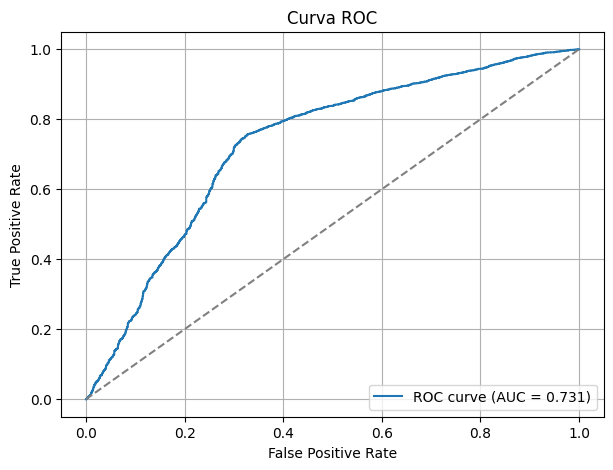

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# 8. Entrenar con pesos
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight,
                    verbose=1)

# 9. Evaluación
y_probs = model.predict(X_test).ravel()
y_pred = (y_probs > 0.5).astype(int)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")

# 10. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Tunner 1

In [17]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}

print(class_weight)

{0: np.float64(3.9088669950738915), 1: np.float64(0.5733381502890174)}


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.metrics import Precision
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 1. Separar en train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Calcular class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}

# 3. Definir modelo
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hp.Int('units1', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', 16, 64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=[Precision()]
    )
    return model

# 4. Crear tuner personalizado
from keras_tuner.engine import tuner as kt_engine

class MyTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['class_weight'] = class_weight
        return super().run_trial(trial, *args, **kwargs)

# 5. Instanciar tuner
tuner = MyTuner(
    build_model,
    objective='val_precision',  # <- maximiza la precisión
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_dir',
    project_name='maximize_precision'
)

# 6. Buscar
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=1)

# 7. Obtener mejor modelo
best_model = tuner.get_best_models(1)[0]

# 8. Evaluar
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_pred = (best_model.predict(X_val).ravel() > 0.5).astype(int)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

Trial 10 Complete [00h 00m 08s]
val_precision: 0.9435982704162598

Best val_precision So Far: 0.9435982704162598
Total elapsed time: 00h 01m 15s
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step
[[ 827  374]
 [2064 6257]]
              precision    recall  f1-score   support

           0       0.29      0.69      0.40      1201
           1       0.94      0.75      0.84      8321

    accuracy                           0.74      9522
   macro avg       0.61      0.72      0.62      9522
weighted avg       0.86      0.74      0.78      9522



/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hp.values

{'units1': 128,
 'dropout1': 0.30000000000000004,
 'units2': 32,
 'lr': 0.00359800375100564}

-****

In [50]:
model = build_model(best_hp)
model.fit(X_train, y_train, 
          epochs=32, 
          validation_data=(X_val, y_val), 
          class_weight=class_weight)

Epoch 1/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.7202 - loss: 0.6148 - val_accuracy: 0.7546 - val_loss: 0.5362
Epoch 2/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step - accuracy: 0.7590 - loss: 0.5800 - val_accuracy: 0.7432 - val_loss: 0.6037
Epoch 3/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7535 - loss: 0.5717 - val_accuracy: 0.7433 - val_loss: 0.6102
Epoch 4/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.7599 - loss: 0.5671 - val_accuracy: 0.7469 - val_loss: 0.5585
Epoch 5/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 459us/step - accuracy: 0.7548 - loss: 0.5621 - val_accuracy: 0.7507 - val_loss: 0.5623
Epoch 6/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.7577 - loss: 0.5617 - val_accuracy: 0.7444 - val_loss: 0.5644
Epoch 7/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - accuracy: 0.7551 - loss: 0.5531 - val_accuracy: 0.7365 - val_loss: 0.6212
Epoch 8/32
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - accuracy: 0.7480 -

In [51]:
# Predecir sobre el conjunto de validación
y_probs = model.predict(X_val).ravel()
y_pred = (y_probs > 0.5).astype(int)

# Métricas de evaluación
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print(f"\nF1 Score: {f1_score(y_val, y_pred):.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step
Confusion Matrix:
[[ 840  361]
 [2537 5784]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.70      0.37      1201
           1       0.94      0.70      0.80      8321

    accuracy                           0.70      9522
   macro avg       0.59      0.70      0.58      9522
weighted avg       0.85      0.70      0.75      9522


F1 Score: 0.7997


In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Probabilidades predichas
y_probs = model.predict(X_val).ravel()

# Lista de umbrales a evaluar
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    print(f"\n🔎 UMBRAL: {t}")
    y_pred = (y_probs > t).astype(int)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, digits=3))
    
    print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step

🔎 UMBRAL: 0.3
Confusion Matrix:
[[ 598  603]
 [1393 6928]]

Classification Report:
              precision    recall  f1-score   support

           0      0.300     0.498     0.375      1201
           1      0.920     0.833     0.874      8321

    accuracy                          0.790      9522
   macro avg      0.610     0.665     0.624      9522
weighted avg      0.842     0.790     0.811      9522

F1 Score: 0.8741

🔎 UMBRAL: 0.4
Confusion Matrix:
[[ 734  467]
 [1776 6545]]

Classification Report:
              precision    recall  f1-score   support

           0      0.292     0.611     0.396      1201
           1      0.933     0.787     0.854      8321

    accuracy                          0.764      9522
   macro avg      0.613     0.699     0.625      9522
weighted avg      0.853     0.764     0.796      9522

F1 Score: 0.8537

🔎 UMBRAL: 0.5
Confusion Matrix:
[[ 840  361]
 [2481 5840]]

Classification Report:
              pre

## f1 

Trial 10 Complete [00h 00m 08s]
val_f1_0: 0.4108190865016586

Best val_f1_0 So Far: 0.4111959287531807
Total elapsed time: 00h 01m 52s
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🔍 Matriz de confusión:
[[ 808  393]
 [1921 6400]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.296     0.673     0.411      1201
           1      0.942     0.769     0.847      8321

    accuracy                          0.757      9522
   macro avg      0.619     0.721     0.629      9522
weighted avg      0.861     0.757     0.792      9522



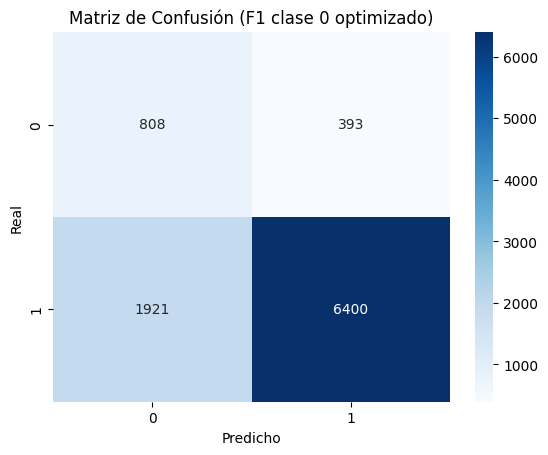

In [52]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.regularizers import l2

from keras_tuner import Objective
from keras_tuner.tuners import RandomSearch

# ----------------------------------
# 1. Preparar datos y class_weight
# ----------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = dict(zip(np.unique(y_train), weights))
print("Class weights:", class_weight)

# ----------------------------------
# 2. Callback personalizado F1 clase 0
# ----------------------------------
class F1Clase0Callback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val).ravel() > 0.5).astype(int)
        f1_0 = f1_score(self.y_val, y_pred, pos_label=0)
        logs["val_f1_0"] = f1_0

# ----------------------------------
# 3. Definir función build_model para Keras Tuner
# ----------------------------------
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    model.add(Dense(hp.Int('units1', 64, 128, step=32), activation='relu',
                    kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.4, step=0.1)))

    model.add(Dense(hp.Int('units2', 32, 64, step=16), activation='relu',
                    kernel_regularizer=l2(0.001)))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# ----------------------------------
# 4. Configurar tuner para F1_0
# ----------------------------------
tuner = RandomSearch(
    build_model,
    objective=Objective("val_f1_0", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    directory='kt_f1_clase0',
    project_name='opt_f1_clase0'
)

# ----------------------------------
# 5. Ejecutar tuner
# ----------------------------------
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        F1Clase0Callback(X_val, y_val)
    ],
    class_weight=class_weight,
    verbose=1
)

# ----------------------------------
# 6. Evaluar el mejor modelo
# ----------------------------------
best_model = tuner.get_best_models(1)[0]
y_pred_prob = best_model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n🔍 Matriz de confusión:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_val, y_pred, digits=3))

# Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (F1 clase 0 optimizado)")
plt.show()

In [23]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [24]:
def focal_loss(alpha=0.75, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(K.equal(y_true, 1), 1 - alpha, alpha)
        focal_weight = alpha_factor * K.pow(1. - pt, gamma)
        return -K.mean(focal_weight * K.log(pt))
    return loss

In [25]:
model.compile(optimizer=Adam(0.001),
              loss=focal_loss(alpha=0.8),  # Más peso a la clase 0
              metrics=[Precision(), Recall()])

In [26]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 689us/step - loss: 0.0377 - precision_2: 0.9602 - recall: 0.7415 - val_loss: 0.0294 - val_precision_2: 0.9542 - val_recall: 0.8364
Epoch 2/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.0321 - precision_2: 0.9479 - recall: 0.8294 - val_loss: 0.0296 - val_precision_2: 0.9533 - val_recall: 0.8328
Epoch 3/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.0312 - precision_2: 0.9515 - recall: 0.8303 - val_loss: 0.0298 - val_precision_2: 0.9540 - val_recall: 0.8358
Epoch 4/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.0315 - precision_2: 0.9496 - recall: 0.8330 - val_loss: 0.0300 - val_precision_2: 0.9526 - val_recall: 0.8418
Epoch 5/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 561us/step - loss: 0.0311 - precision_2: 0.9497 - recall: 0.8327 - val_loss: 0.0301 - val_precision_2: 0.9510 - val_recall: 0.8409
Epoch 6/10
953/953 ━━━━━━━━━━━━━━━━━━━━ 1s 555us/step - loss: 0.0301 - precision_2: 0.9538 - recall: 0.8355 - val_loss: 0.0304 - val_precisio

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


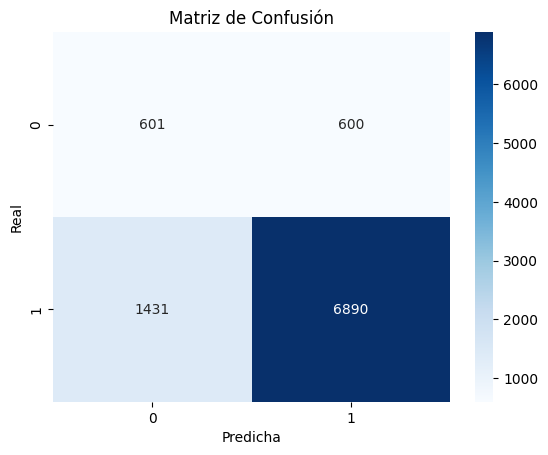

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicha")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.50      0.37      1201
           1       0.92      0.83      0.87      8321

    accuracy                           0.79      9522
   macro avg       0.61      0.66      0.62      9522
weighted avg       0.84      0.79      0.81      9522



In [30]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}

print(class_weight)

{0: np.float64(3.9088669950738915), 1: np.float64(0.5733381502890174)}


In [31]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.metrics import Precision
from keras.metrics import Recall
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 1. Separar en train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Calcular class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}

# 3. Definir modelo
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hp.Int('units1', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', 16, 64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=[Precision(),Recall()]
    )
    return model

# 4. Crear tuner personalizado
from keras_tuner.engine import tuner as kt_engine

class MyTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['class_weight'] = class_weight
        return super().run_trial(trial, *args, **kwargs)

# 5. Instanciar tuner
tuner = MyTuner(
    build_model,
    objective='val_recall',  # <- maximiza la precisión
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_dir',
    project_name='maximize_precision'
)

# 6. Buscar
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=10, verbose=1)

# 7. Obtener mejor modelo
best_model = tuner.get_best_models(1)[0]

# 8. Evaluar
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_pred = (best_model.predict(X_val).ravel() > 0.5).astype(int)
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

Trial 10 Complete [00h 00m 08s]
val_recall: 0.770460307598114

Best val_recall So Far: 0.7726234793663025
Total elapsed time: 00h 01m 18s
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
[[ 798  403]
 [1892 6429]]
              precision    recall  f1-score   support

           0       0.30      0.66      0.41      1201
           1       0.94      0.77      0.85      8321

    accuracy                           0.76      9522
   macro avg       0.62      0.72      0.63      9522
weighted avg       0.86      0.76      0.79      9522



/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


****

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback

from keras_tuner import RandomSearch, Objective

# -----------------------------
# 1. Separar datos en train/val
# -----------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# 2. Calcular class_weight
# -----------------------------
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}

# -----------------------------
# 3. Definir modelo tunable
# -----------------------------
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(hp.Int('units1', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.5, step=0.1)))
    model.add(Dense(hp.Int('units2', 16, 64, step=16), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']  # Puedes añadir más si quieres verlas, pero solo maximizamos recall_0
    )
    return model

# -----------------------------
# 4. Callback personalizado para recall clase 0
# -----------------------------
class RecallClase0Callback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred_prob = self.model.predict(self.X_val)
        y_pred = (y_pred_prob > 0.5).astype(int)
        recall_0 = recall_score(self.y_val, y_pred, pos_label=0)
        logs["val_recall_0"] = recall_0

# -----------------------------
# 5. Tuner con objetivo personalizado
# -----------------------------
tuner = RandomSearch(
    build_model,
    objective=Objective("val_recall_0", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_dir',
    project_name='maximize_recall_clase0'
)

# -----------------------------
# 6. Lanzar búsqueda
# -----------------------------
recall_callback = RecallClase0Callback(X_val, y_val)

tuner.search(X_train, y_train,
             validation_data=(X_val, y_val),
             epochs=10,
             callbacks=[recall_callback],
             class_weight=class_weight)

# -----------------------------
# 7. Evaluar el mejor modelo
# -----------------------------
best_model = tuner.get_best_models(1)[0]

y_pred_prob = best_model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Matriz de confusión:")
print(confusion_matrix(y_val, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred))

Trial 10 Complete [00h 00m 09s]
val_recall_0: 0.6769358867610324

Best val_recall_0 So Far: 0.6927560366361366
Total elapsed time: 00h 01m 27s
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 255us/step
Matriz de confusión:
[[ 832  369]
 [2194 6127]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.27      0.69      0.39      1201
           1       0.94      0.74      0.83      8321

    accuracy                           0.73      9522
   macro avg       0.61      0.71      0.61      9522
weighted avg       0.86      0.73      0.77      9522



/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
# Obtener el mejor trial
best_trial = tuner.get_best_hyperparameters(1)[0]

# Mostrar los valores seleccionados
print("Mejores hiperparámetros encontrados:")
for key in best_trial.values:
    print(f"{key}: {best_trial.values[key]}")

Mejores hiperparámetros encontrados:
units1: 96
dropout1: 0.0
units2: 16
lr: 0.005910286085987312


In [34]:
from tensorflow.keras.callbacks import EarlyStopping

# Crear modelo final
final_model = Sequential()
final_model.add(Input(shape=(X_train.shape[1],)))
final_model.add(Dense(128, activation='relu'))
final_model.add(Dense(48, activation='relu'))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(
    optimizer=Adam(learning_rate=0.0038591074566364392),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callback para detener si no mejora
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar con más épocas y pesos de clase
final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weight
)

Epoch 1/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.7348 - loss: 0.6008 - val_accuracy: 0.7528 - val_loss: 0.5247
Epoch 2/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.7507 - loss: 0.5746 - val_accuracy: 0.7484 - val_loss: 0.5526
Epoch 3/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 508us/step - accuracy: 0.7542 - loss: 0.5669 - val_accuracy: 0.7180 - val_loss: 0.6783
Epoch 4/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.7477 - loss: 0.5740 - val_accuracy: 0.7497 - val_loss: 0.5731
Epoch 5/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.7588 - loss: 0.5449 - val_accuracy: 0.7400 - val_loss: 0.6054
Epoch 6/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - accuracy: 0.7520 - loss: 0.5520 - val_accuracy: 0.7342 - val_loss: 0.6002
Epoch 7/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7561 - loss: 0.5334 - val_accuracy: 0.7366 - val_loss: 0.5698
Epoch 8/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step - accuracy: 0.7540 -

In [35]:
y_pred_prob = final_model.predict(X_val).ravel()  # Probabilidades
y_pred = (y_pred_prob > 0.5).astype(int)          # Clasificaciones (0 o 1)

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


In [36]:
from sklearn.metrics import classification_report

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.68      0.41      1201
           1       0.94      0.76      0.84      8321

    accuracy                           0.75      9522
   macro avg       0.62      0.72      0.63      9522
weighted avg       0.86      0.75      0.79      9522



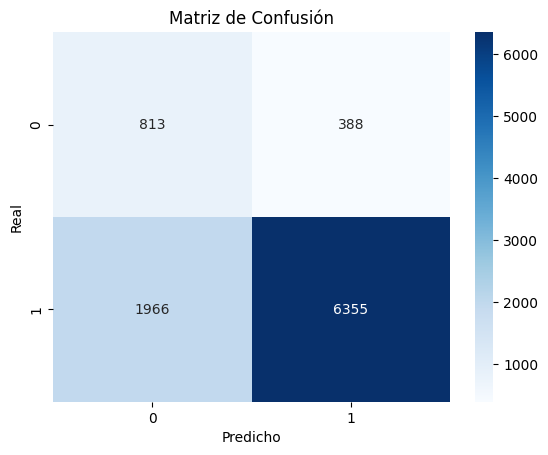

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 🧠 Modelo con 3 capas ocultas
model_3capas = Sequential()
model_3capas.add(Input(shape=(X_train.shape[1],)))
model_3capas.add(Dense(96, activation='relu'))   # Capa 1
model_3capas.add(Dense(64, activation='relu'))   # Capa 2
model_3capas.add(Dense(32, activation='relu'))   # Capa 3
model_3capas.add(Dense(1, activation='sigmoid')) # Capa de salida

# Compilación
model_3capas.compile(
    optimizer=Adam(learning_rate=0.00386),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento con class_weight
model_3capas.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight={0: 4.0, 1: 1.0},  # puedes ajustar el peso aquí
    verbose=1
)

Epoch 1/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.7782 - loss: 0.7999 - val_accuracy: 0.7582 - val_loss: 0.4443
Epoch 2/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 590us/step - accuracy: 0.7637 - loss: 0.7597 - val_accuracy: 0.7603 - val_loss: 0.4456
Epoch 3/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 569us/step - accuracy: 0.7656 - loss: 0.7421 - val_accuracy: 0.7568 - val_loss: 0.4822
Epoch 4/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.7646 - loss: 0.7433 - val_accuracy: 0.7566 - val_loss: 0.4780
Epoch 5/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.7678 - loss: 0.7394 - val_accuracy: 0.7552 - val_loss: 0.4759
Epoch 6/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - accuracy: 0.7763 - loss: 0.7246 - val_accuracy: 0.7556 - val_loss: 0.4808


298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step

Matriz de confusión:
[[ 782  419]
 [1848 6473]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.30      0.65      0.41      1201
           1       0.94      0.78      0.85      8321

    accuracy                           0.76      9522
   macro avg       0.62      0.71      0.63      9522
weighted avg       0.86      0.76      0.80      9522



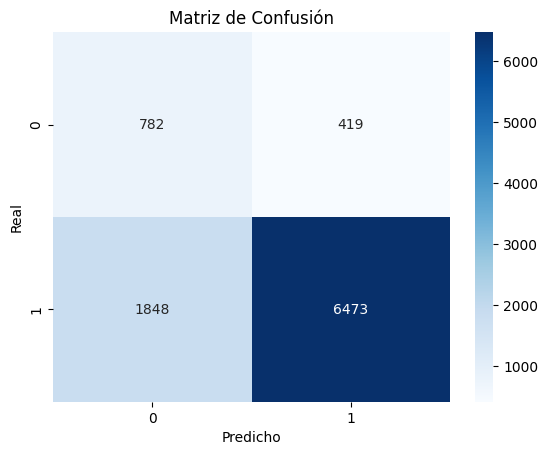

In [ ]:
# Predicciones
y_pred_prob = model_3capas.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Reporte de métricas
print("\nMatriz de confusión:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred))

# Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

from keras_tuner.tuners import RandomSearch
from keras_tuner import Objective

# -------------------------------------------
# 1. Dividir en train / val
# -------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------------------
# 2. Definir class_weight manual
# -------------------------------------------
class_weight = {0: 4.0, 1: 1.0}  # ajusta si quieres

# -------------------------------------------
# 3. Callback para calcular recall clase 0
# -------------------------------------------
class RecallClase0Callback(Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val).ravel() > 0.5).astype(int)
        recall_0 = recall_score(self.y_val, y_pred, pos_label=0)
        logs['val_recall_0'] = recall_0

# -------------------------------------------
# 4. Definir modelo con 3 capas ocultas
# -------------------------------------------
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    model.add(Dense(hp.Int('units1', 64, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout1', 0.0, 0.3, step=0.1)))

    model.add(Dense(hp.Int('units2', 32, 96, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.0, 0.3, step=0.1)))

    model.add(Dense(hp.Int('units3', 16, 64, step=16), activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# -------------------------------------------
# 5. Configurar Keras Tuner
# -------------------------------------------
tuner = RandomSearch(
    build_model,
    objective=Objective("val_recall_0", direction="max"),
    max_trials=10,
    executions_per_trial=1,
    directory='kt_3layers',
    project_name='recall_clase0'
)

# -------------------------------------------
# 6. Ejecutar búsqueda
# -------------------------------------------
recall_callback = RecallClase0Callback(X_val, y_val)

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[recall_callback],
    class_weight=class_weight,
    verbose=1
)

# -------------------------------------------
# 7. Evaluar el mejor modelo
# -------------------------------------------
best_model = tuner.get_best_models(1)[0]

y_pred_prob = best_model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n🔍 Matriz de confusión:")
print(confusion_matrix(y_val, y_pred))

print("\n📋 Reporte de clasificación:")
print(classification_report(y_val, y_pred))

Trial 10 Complete [00h 00m 16s]
val_recall_0: 0.6777685262281432

Best val_recall_0 So Far: 0.6860949208992506
Total elapsed time: 00h 02m 41s
298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step

🔍 Matriz de confusión:
[[ 824  377]
 [2036 6285]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.29      0.69      0.41      1201
           1       0.94      0.76      0.84      8321

    accuracy                           0.75      9522
   macro avg       0.62      0.72      0.62      9522
weighted avg       0.86      0.75      0.78      9522



/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.7821 - loss: 0.8801 - val_accuracy: 0.7595 - val_loss: 0.4961
Epoch 2/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.7757 - loss: 0.7878 - val_accuracy: 0.7579 - val_loss: 0.4835
Epoch 3/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - accuracy: 0.7723 - loss: 0.7830 - val_accuracy: 0.7632 - val_loss: 0.4420
Epoch 4/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step - accuracy: 0.7743 - loss: 0.7738 - val_accuracy: 0.7633 - val_loss: 0.4701
Epoch 5/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - accuracy: 0.7715 - loss: 0.7735 - val_accuracy: 0.7700 - val_loss: 0.4278
Epoch 6/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.7693 - loss: 0.7794 - val_accuracy: 0.7577 - val_loss: 0.4495
Epoch 7/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - accuracy: 0.7736 - loss: 0.7679 - val_accuracy: 0.7555 - val_loss: 0.4757
Epoch 8/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.7697 -

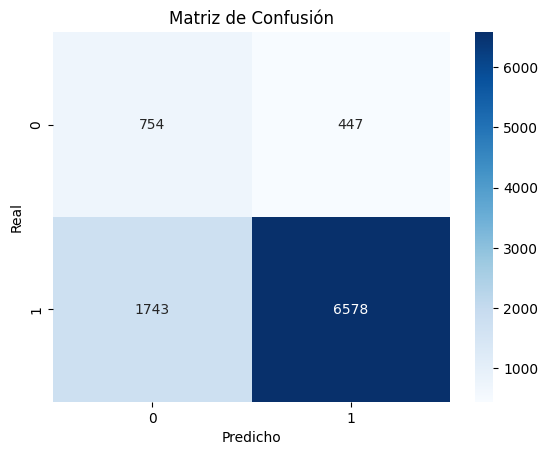

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🧠 Modelo con regularización
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# Primera capa con regularización y dropout
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))

# Segunda capa con regularización
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))

# Capa de salida
model.add(Dense(1, activation='sigmoid'))

# Compilar
model.compile(
    optimizer=Adam(learning_rate=0.0036),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenar
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight={0: 4.0, 1: 1.0},  # mismo peso que antes
    verbose=1
)

# Predicción
y_pred_prob = model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluar
print("\n🔍 Matriz de confusión:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_val, y_pred))

# Visualizar matriz
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

298/298 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step

🔍 Matriz de confusión:
[[ 803  398]
 [1901 6420]]

📋 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.30      0.67      0.41      1201
           1       0.94      0.77      0.85      8321

    accuracy                           0.76      9522
   macro avg       0.62      0.72      0.63      9522
weighted avg       0.86      0.76      0.79      9522



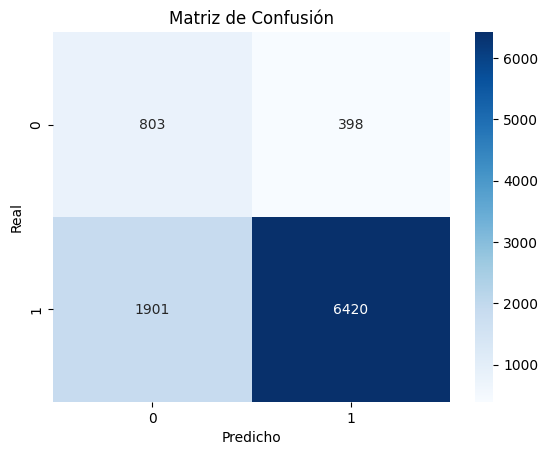

In [44]:
y_pred_prob = model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.6).astype(int)

# Evaluar
print("\n🔍 Matriz de confusión:")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_val, y_pred))

# Visualizar matriz
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

Class weights: {np.int64(0): np.float64(3.9088669950738915), np.int64(1): np.float64(0.5733381502890174)}
Epoch 1/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.7306 - loss: 0.6754 - val_accuracy: 0.7483 - val_loss: 0.6177
Epoch 2/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.7536 - loss: 0.6019 - val_accuracy: 0.7357 - val_loss: 0.6767
Epoch 3/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.7501 - loss: 0.5975 - val_accuracy: 0.7464 - val_loss: 0.6300
Epoch 4/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 479us/step - accuracy: 0.7572 - loss: 0.5884 - val_accuracy: 0.7527 - val_loss: 0.5750
Epoch 5/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 615us/step - accuracy: 0.7541 - loss: 0.5968 - val_accuracy: 0.7499 - val_loss: 0.6272
Epoch 6/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step - accuracy: 0.7547 - loss: 0.5930 - val_accuracy: 0.7497 - val_loss: 0.6013
Epoch 7/50
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - accuracy: 0.7574 - loss: 0.5881 - val_accura

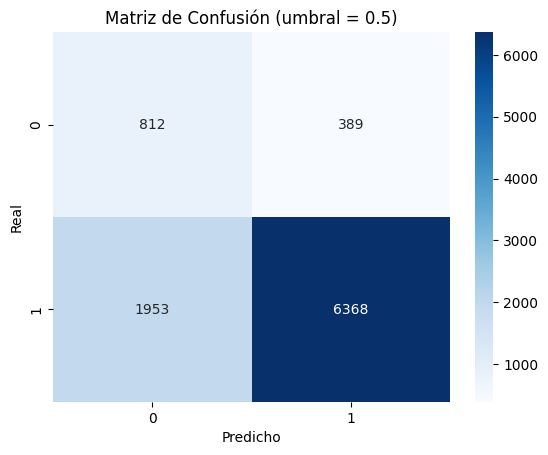

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# 1. Dividir datos
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Calcular class_weight automáticamente
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = dict(zip(classes, weights))
print("Class weights:", class_weight)

# 3. Definir modelo
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(learning_rate=0.0036),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Entrenar
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)

# 5. Predicción con umbral fijo en 0.5
y_pred_prob = model.predict(X_val).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

# 6. Evaluación
print("\n🔍 Matriz de confusión (umbral = 0.5):")
cm = confusion_matrix(y_val, y_pred)
print(cm)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_val, y_pred, digits=3))

# 7. Visualización
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión (umbral = 0.5)")
plt.show()